# Digital Diagnosis: Children's Pnemonia Identification via Chest X-rays

# Business Problem

Pneumonia is a common infection that causes inflammation and possible fluid accumulation in the air sacs of the lungs.


[In China, pneumonia is one of the leading causes of death for children under 5 years old](https://journals.lww.com/md-journal/Fulltext/2018/11160/The_drug_use_to_treat_community_acquired_pneumonia.42.aspx#:~:text=More%20than%202%20million%200,the%20age%20of%205%20years.)


Causes of pneumonia include bactria, virus and fungal sources. 

[Pediatric pneumonia is generally diagnosed based on the time of the year and the results of a physical exam, paying attention the child's breathing and listening to the lungs](https://www.nationwidechildrens.org/conditions/pneumonia). Further testing can include blood tests and chest X-rays. 


Even with modern medicine, pneumonia can be misdiagnosed. A fast and accurate diagnosis allow doctors to treat the infection with the appropirate care. 


One application of machine learning in medicine is digital diagnosis. 


We have been tasked with developing an identification model to determine if a chest X-ray indicates the presence of pneumonia. False negative results are to be minimized compared to false positives.

The data is sourced from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). It is already split into three folders for training, validation and testing. All the chest radiographs were screened for quality and diagnostic labeling performed by physicians. The images were collected during routine clinicial care of pediatric patients between one and five years old from Guangzhou Women and Children's Medical Center in Guangzhou, China.

# Imports

In [180]:
import os
from os import listdir
from os.path import isfile, join

from PIL import Image
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense

os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict

## Helper Functions

Helper functions:
- get_ratio: return the ratio of an 2D image array width:height
- resize_and_crop: returns a scaled and cropped image

In [181]:
def get_ratio(array):
    return array.shape[0]/array.shape[1]

def resize_and_crop(image, new_size=256):
    """
    This function will take in an image, resize and crop it to a square.
    The default new length for a side is 256 pixels.
    The function will output a new square, centered image.
    
    """
    # get width and height from passed image   
    width, height = image.size
    
    # set up variables for new width and height
    new_width = 0
    new_height = 0
    
    # based on larger side changing to new_size, calculate the ratio and length of
    # the shorter side
    if width > height:
        ratio_wh = width / height
        new_width = int(ratio_wh * new_size)
        new_height = new_size
    else:
        ratio_hw = height / width
        new_width = new_size
        new_height = int(ratio_hw * new_size)
        
    # save the scaled image
    scaled_image = image.resize((new_width, new_height))
    
    # if the image is wider, crop in equally from the sides to preserve center of image
    if new_width > new_height:
        # we are only cropping in from left and right, so set top crop to 0 and bottom to new_size
        top = 0
        bottom = new_size
        # set the left and right side crop values
        left = int(math.ceil((new_width - new_size) / 2))
        right = new_width - int(math.floor((new_width - new_size) / 2))
        # save the cropped image
        cropped_image = scaled_image.crop((left, top, right, bottom))
    
    # if the image is taller, crop equally from the top/bottom to preserve center of image
    else:
        # we are only cropping top and bottom, so set left crop to 0 and right crop to new_size
        left = 0
        right = new_size
        # set the top and bottom crop values
        top = int(math.ceil((new_height - new_size) / 2))
        bottom = new_height - int(math.floor((new_height - new_size) / 2))
        # save the cropped image
        cropped_image = scaled_image.crop((left, top, right, bottom))
    
    return cropped_image

def model_report(model, X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test):
    """
    This helper function will allow us to quickly evaluate models that we
    create by reporting the classification report and displaying a confusion
    matrix
    
    Input(s)
    - the model to report on
    - the X_train (default to X_train)
    - the y_train (default to y_train)
    - the X_test (default to X_test)
    - the y_test (default to y_test)  
    """
    # create the y_pred 
    y_pred = model.predict(X_test)
    
    # generate the confusion matrix
    cmatrix = confusion_matrix(y_test, y_pred)
    # convert into dataframe
    cmatrix_df = pd.DataFrame(cmatrix)
    
    # print the classification report
    print(classification_report(y_test, y_pred)) #target_names=))
    # show report as heatmap   
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(data=cmatrix_df, annot=True, cmap='Blues', fmt='g')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)

# EDA

## Image ratios

For best results in modeling, we need to standardize and shrink the images. It was advised to scale images to 256x256. During initial investigation into the image dimensions, we saw that some of our images have a dimension below that value. To get a better picture of what our dataset contains, we will go through all the files contained in all folders of our chest_xray images. We set our minimum dimension to 256, but this can easily be updated. If an image contains a dimension lower than our minimum we will separate it out into one dataframe and all other images will be in another dataframe.

In [43]:
folder_names = ['train', 'test', 'val']
img_names = ['NORMAL', 'PNEUMONIA']

min_size = 256

all_images = []
small_images = []

# loop through the different combinations of folder name prefixes
for folder in folder_names:
    for img_type in img_names:
        
        # set up the path to each folder of images
        path = f'./chest_xray/{folder}/{img_type}'
        
        # create a list of the filenames in that directory
        filelist = list(listdir(path))
        
        # loop through each file in the folder
        for file_name in filelist:
            
            # set the filepath for the file in question
            filepath = path + r'/' + file_name
            
            # open the image
            image = Image.open(filepath)
            
            # convert the few B/W images coded as RGB back to greyscale
            if image.mode == 'RGB':
                image = image.convert('L')
            
            # convert the image into an array
            image_array = np.asarray(image)
            
            # get the ratio, height, and width of the image
            ratio = get_ratio(image_array)
            height, width = image_array.shape            
            
            # if either measurement is under our defined minimum size,
            # append the data as a tuple to small_images. Otherwise, add
            # it to the all_images list
            if (width < min_size) or (height < min_size):
                small_images.append((folder, img_type, file_name, ratio, width, height))
            else:
                all_images.append((folder, img_type, file_name, ratio, width, height))

# set the column names
column_names = ['folder', 'img_type', 'file_name', 'ratio', 'width', 'height']
# convert both lists to dataframes
small_images_df = pd.DataFrame(small_images, columns=column_names)
all_images_df = pd.DataFrame(all_images, columns=column_names)

In [55]:
small_images_df.describe()

,ratio,width,height
count,58.000000,58.000000,58.000000
mean,0.419099,472.534483,197.844828
std,0.068402,38.802792,34.266142
min,0.295964,384.000000,127.000000
25%,0.380386,445.250000,175.500000
50%,0.407094,467.500000,195.000000
75%,0.477534,495.500000,229.000000
max,0.578231,564.000000,255.000000


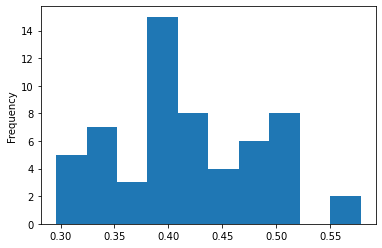

In [53]:
small_images_df.ratio.plot(kind='hist');

In [118]:
print('Small image folder representation')
display(small_images_df.folder.value_counts())
print('Small image type representation')
display(small_images_df.img_type.value_counts())

Small image folder representation


train    58
Name: folder, dtype: int64

Small image type representation


PNEUMONIA    58
Name: img_type, dtype: int64

We can see here that there are only 58 images out of our total 5856 which have a dimension less than our minimum. We will not consider those in constructing our image data arrays.
__________________

Let's consider the ratios of the all the rest of the images.

In [56]:
all_images_df.describe()

,ratio,width,height
count,5798.000000,5798.000000,5798.000000
mean,0.715844,1336.437220,978.420145
std,0.113936,355.030906,377.376302
min,0.387387,415.000000,256.000000
25%,0.632822,1064.000000,696.000000
50%,0.707828,1288.000000,888.000000
75%,0.793645,1562.000000,1192.000000
max,1.197044,2916.000000,2713.000000


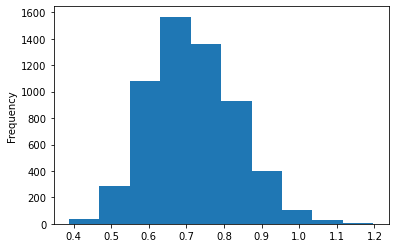

In [52]:
all_images_df.ratio.plot(kind='hist');

Most of our images have a ratio above 0.63, but there are some as low as 0.38. It's suspected that cropping the images that we have with low ratio (which indicates very wide images) may be problematic, so it may be something we have to return to and consider dropping some images with a ratio below a certain threshold. We can do some quick investigation into that.

## Testing Cropping

In [115]:
def compare_cropping(index_value, df=all_images_df):
    """
    This helper function will take in the index value of an image in the default
    dataframe: all_images_df. It will display the width, height, and ratio of the
    original with the original image. It will then perform the cropping and display
    the new imaged data along with the new cropped image for comparison.   
    """
    # Get the folder and img_type value from the dataframe to contsruct the folder root
    folder = df.iloc[index_value]['folder']
    img_type = df.iloc[index_value]['img_type']
    # constrcut the folder root for the file in question
    root=f"./chest_xray/{folder}/{img_type}/"
    # set the image path and open the image
    image_path = root + df.iloc[index_value]['file_name']
    image = Image.open(image_path)
    # print the dimensions, ratio, and original image
    print(f"width: {image.width}\theight: {image.height}\tratio: {image.height/image.width}")
    display(image)
    # crop the image
    cropped_image = resize_and_crop(image)
    # print the new image (will be 256x256 with ratio of 1.0)
    display(cropped_image)

Let's look at an image with our 25th percentile value for ratio: 0.63

In [119]:
all_images_df[all_images_df.ratio == 0.63]

,folder,img_type,file_name,ratio,width,height
5317,test,NORMAL,NORMAL2-IM-0283-0001.jpeg,0.63,1400,882


width: 1400	height: 882	ratio: 0.63


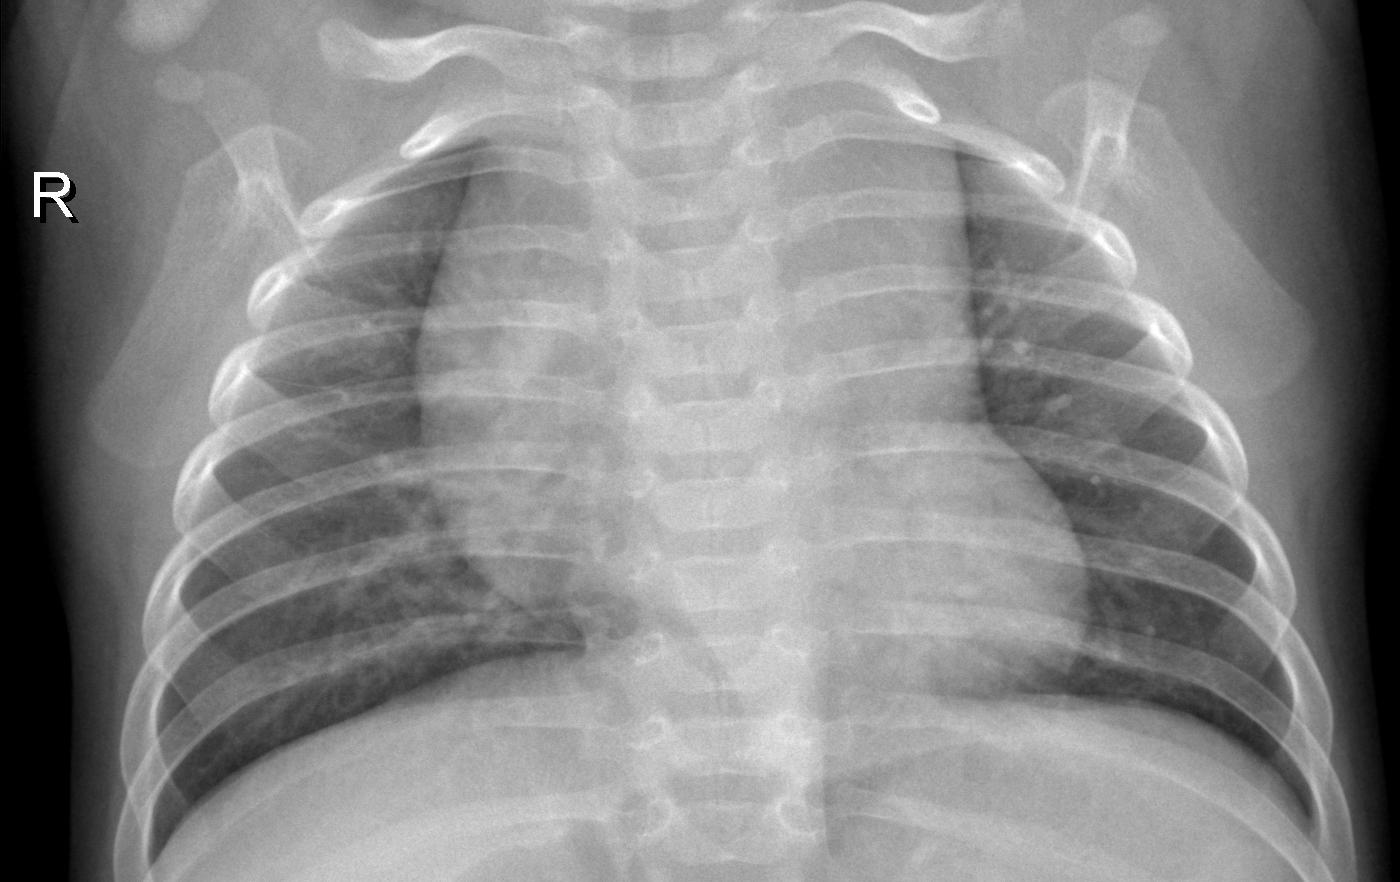

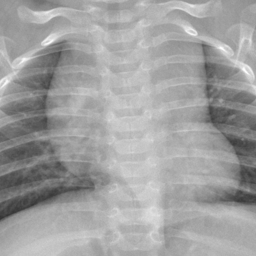

In [120]:
compare_cropping(5317)

Here we can see we are losing some of our image on the sides of the chest cavity. We know that data is expensive, so we want to use the most of our images that we can. For arguments' sake, if we were willing to lose the worst 5% of our images based on ratio, let's examine an image with the ratio of the 5% quantile.

In [121]:
all_images_df.quantile(q=0.05)

ratio       0.54482
width     860.85000
height    528.00000
Name: 0.05, dtype: float64

In [128]:
all_images_df[all_images_df.ratio == 0.55]

,folder,img_type,file_name,ratio,width,height
1940,train,PNEUMONIA,person1308_bacteria_3288.jpeg,0.55,1440,792
3146,train,PNEUMONIA,person287_bacteria_1354.jpeg,0.55,1120,616


width: 1440	height: 792	ratio: 0.55


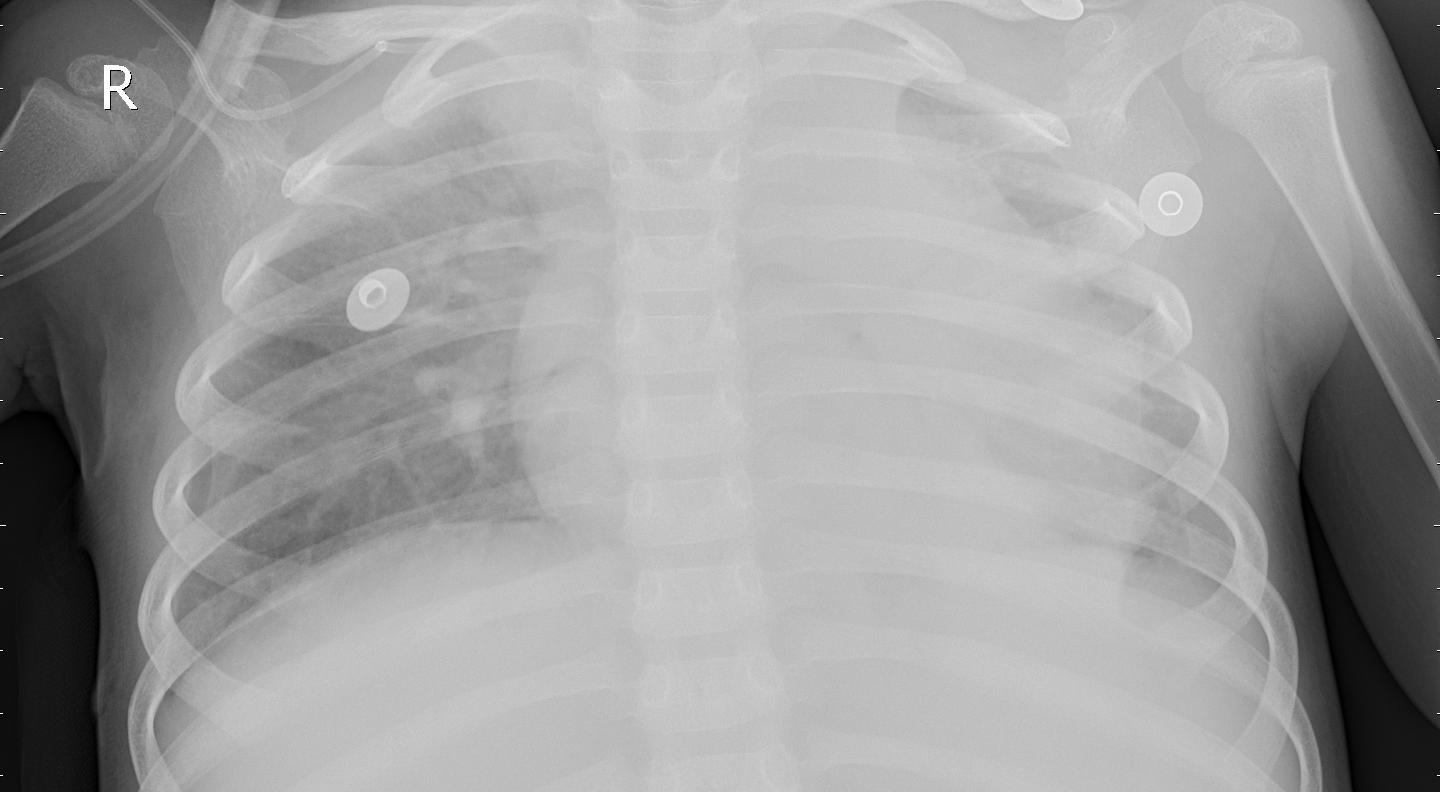

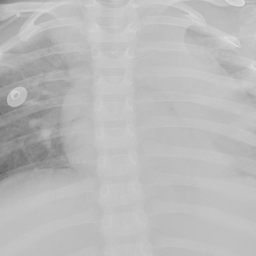

In [129]:
compare_cropping(1940)

In [134]:
all_images_df[all_images_df.ratio <= 0.55].folder.value_counts()

train    283
test      44
Name: folder, dtype: int64

In [135]:
all_images_df[all_images_df.ratio <= 0.55].img_type.value_counts()

PNEUMONIA    321
NORMAL         6
Name: img_type, dtype: int64

In [132]:
len(all_images_df[all_images_df.ratio <= 0.55])/len(all_images_df)

0.056398758192480164

If we see impact during modeling, we may consider dropping images with ratios less than 0.55 from consideration. Most of the images are from our training set of positive cases (which we have a large majority of).

# Image Preprocessing

This next cell will run very much the same way when we were investigating the image ratios. This time, the goal will be to create arrays of images as arrays that will then be saved to disk for use in modeling (especially if we want to use a cloud-based service to run on ). Initially, the min_ratio for images is not set. In order to set it, update the value at the top of the cell and uncomment the lines below setting ratio (there is comment directing this)

In [147]:
# folder_names and img_names were set earlier
# min_size was set earlier to 256

min_ratio = None

# loop through the different combinations of folder name prefixes
for folder in folder_names:
    for img_type in img_names:
        
        # set up the path to each folder of images
        path = f'./chest_xray/{folder}/{img_type}'
        
        # create a list of the filenames in that directory
        filelist = list(listdir(path))
        
        # create empty lists for the image arrays and target values
        array_list = []
        target_list = []
        
        # loop through each file in the folder
        for file_name in filelist:
            
            # set the filepath for the file in question
            filepath = path + r'/' + file_name
            
            # open the image
            image = Image.open(filepath)
            
            # some of our images are in RGB and need to convert to greyscale
            if image.mode == 'RGB':
                image = image.convert('L')
            
            # there are a small number of images with a dimension less than our minimum
            # we are dropping them from consideration
            if (image.height < min_size) or (image.width < min_size):
                continue
            
            # resize and crop the image
            image_modified = resize_and_crop(image)

            # convert the image to a numpy array
            image_as_array = np.asarray(image_modified)
            
            # here is where we can update to not consider images below a certain ratio
            ratio = get_ratio(image_as_array)
#             if ratio <= min_ratio:
#                 continue
            
            # append the image array to the array_list
            array_list.append(image_as_array)
        
            # set the target value based on the img_type and append to target_list
            if img_type == 'NORMAL':
                target_list.append(0)
            else:
                target_list.append(1)
        
        # set path for saving numpy data
        data_path = f'./data/'
        
        final_array = np.asarray(array_list)
        target_array = np.asarray(target_list)
        
        np.save(file=f'{data_path}{folder}_{img_type.lower()}_data.npy', arr=final_array)
        np.save(file=f'{data_path}{folder}_{img_type.lower()}_target.npy', arr=target_array)

# Loading Data

In [148]:
# set the data path and get the list of files
data_path = f"./data/"
data_files = list(listdir(data_path))

# loop through each file
for file in data_files:
    
    # split off the components of the file name
    folder, image, xy = file[:-4].split('_')
    # set a global variable loading the data from the file
    globals()[f"{folder}_{image}_{xy}"] = np.load(data_path + file)

# set train data and target
train_data = np.concatenate((train_normal_data, train_pneumonia_data))
y_train = np.concatenate((train_normal_target, train_pneumonia_target))

# set validation data and target
val_data = np.concatenate((val_normal_data, val_pneumonia_data))
y_val = np.concatenate((val_normal_target, val_pneumonia_target))

# set testing data and target
test_data = np.concatenate((test_normal_data, test_pneumonia_data))
y_test = np.concatenate((test_normal_target, test_pneumonia_target))

# verify shapes are accurate
print(f"Train data/target shapes: {train_data.shape}, {y_train.shape}")
print(f"Val data/target shapes: {val_data.shape}, {y_val.shape}")
print(f"Test data/target shapes: {test_data.shape}, {y_test.shape}")

Train data/target shapes: (5158, 256, 256), (5158,)
Val data/target shapes: (16, 256, 256), (16,)
Test data/target shapes: (624, 256, 256), (624,)


In [149]:
# set the lengths of each set of data
train_len = train_data.shape[0]
val_len = val_data.shape[0]
test_len = test_data.shape[0]

# set the new rehape size for the images
img_size = train_data.shape[1] ** 2

# reshape all three data groups
X_train = train_data.reshape(train_len, img_size).astype('float32')
X_val = val_data.reshape(val_len, img_size).astype('float32')
X_test = test_data.reshape(test_len, img_size).astype('float32')

# verify shapes are accurate
print(f"New train data shape: {X_train.shape}")
print(f"New val data shape: {X_val.shape}")
print(f"New test data shape: {X_test.shape}")

New train data shape: (5158, 65536)
New val data shape: (16, 65536)
New test data shape: (624, 65536)


In [150]:
# normalize the data
X_train /= 255.
X_val /= 255.
X_test /= 255.

# First model

In [160]:
model_1 = Sequential()
model_1.add(Dense(10, activation='tanh', input_shape=(65536,)))
model_1.add(Dense(10, activation='tanh', input_shape=(65536,)))
model_1.add(Dense(1, activation='sigmoid'))

In [161]:
model_1.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['binary_accuracy'])

In [162]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                655370    
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 655,381
Trainable params: 655,381
Non-trainable params: 0
_________________________________________________________________


In [163]:
results_1 = model_1.fit(X_train, y_train,
                        epochs=5,
                        batch_size=64,
                        validation_data=(X_val, y_val))

Epoch 1/5
81/81 [==============================] - 2s 12ms/step - loss: 0.8405 - binary_accuracy: 0.7400 - val_loss: 1.3897 - val_binary_accuracy: 0.5000
Epoch 2/5
81/81 [==============================] - 1s 11ms/step - loss: 0.6908 - binary_accuracy: 0.7400 - val_loss: 1.0950 - val_binary_accuracy: 0.5000
Epoch 3/5
81/81 [==============================] - 1s 11ms/step - loss: 0.6056 - binary_accuracy: 0.7400 - val_loss: 0.9239 - val_binary_accuracy: 0.5000
Epoch 4/5
81/81 [==============================] - 1s 12ms/step - loss: 0.5779 - binary_accuracy: 0.7400 - val_loss: 0.8506 - val_binary_accuracy: 0.5000
Epoch 5/5
81/81 [==============================] - 1s 11ms/step - loss: 0.5734 - binary_accuracy: 0.7400 - val_loss: 0.8278 - val_binary_accuracy: 0.5000


In [168]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_binary_accuracy'])
    plt.plot(history['binary_accuracy'])
    plt.legend(['val_binacc', 'binacc'])
    plt.title('Binary Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

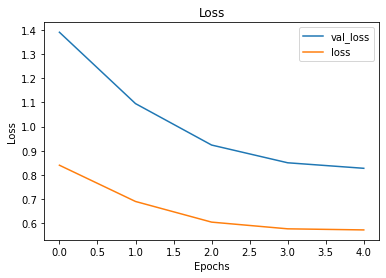

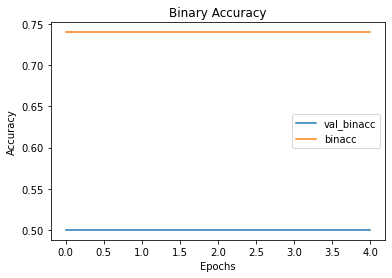

In [169]:
visualize_training_results(results_1)

In [185]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [186]:
y_pred = model_1.predict(X_val)
y_pred

array([[0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174],
       [0.74294174]], dtype=float32)

In [187]:
y_pred.shape

(16, 1)

In [188]:
y_val.shape

(16,)

In [189]:
y_pred = np.transpose(y_pred)[0]

In [190]:
y_pred.shape

(16,)

In [191]:
y_pred

array([0.74294174, 0.74294174, 0.74294174, 0.74294174, 0.74294174,
       0.74294174, 0.74294174, 0.74294174, 0.74294174, 0.74294174,
       0.74294174, 0.74294174, 0.74294174, 0.74294174, 0.74294174,
       0.74294174], dtype=float32)

In [182]:
model_report(model_1)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

This doesn't look great. Our model accuracy is at 74% and steady, and the validation is at 50%. Unsurprisingly, these are the percentages of our data that are labeled with pneumonia (74% for training, 50% for validation). 

In [192]:
model_2 = Sequential()
model_2.add(Dense(50, activation='relu', input_shape=(65536,)))
model_2.add(Dense(25, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [193]:
model_2.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['binary_accuracy'])

In [194]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 50)                3276850   
                                                                 
 dense_12 (Dense)            (None, 25)                1275      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3,278,151
Trainable params: 3,278,151
Non-trainable params: 0
_________________________________________________________________


In [197]:
results_2 = model_2.fit(X_train, y_train,
                        epochs=25,
                        batch_size=64,
                        validation_data=(X_val, y_val))

Epoch 1/25
81/81 [==============================] - 2s 26ms/step - loss: 0.1416 - binary_accuracy: 0.9469 - val_loss: 0.9386 - val_binary_accuracy: 0.6875
Epoch 2/25
81/81 [==============================] - 2s 23ms/step - loss: 0.2479 - binary_accuracy: 0.9153 - val_loss: 0.3775 - val_binary_accuracy: 0.8750
Epoch 3/25
81/81 [==============================] - 2s 23ms/step - loss: 0.1820 - binary_accuracy: 0.9331 - val_loss: 0.3601 - val_binary_accuracy: 0.8125
Epoch 4/25
81/81 [==============================] - 2s 22ms/step - loss: 0.1841 - binary_accuracy: 0.9318 - val_loss: 0.3721 - val_binary_accuracy: 0.8750
Epoch 5/25
81/81 [==============================] - 2s 22ms/step - loss: 0.1684 - binary_accuracy: 0.9407 - val_loss: 0.4595 - val_binary_accuracy: 0.8750
Epoch 6/25
81/81 [==============================] - 2s 21ms/step - loss: 0.1572 - binary_accuracy: 0.9434 - val_loss: 0.3936 - val_binary_accuracy: 0.8125
Epoch 7/25
81/81 [==============================] - 2s 21ms/step - los

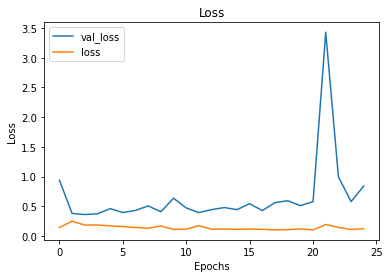

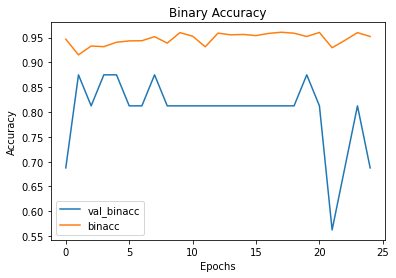

In [198]:
visualize_training_results(results_2)